# Analyzing Solid Oxide Fuel Cell data (part 1)
###Note: The analysis in this notebook failed. Please begin with part 2 unless you are referencing the figures.

In this series of notebooks, I will analyze diffusion data for materials used in Solid Oxide Fuel Cell (SOFC) cathodes. There are roughly 120 measurements, each collected from experiments published in journal articles. The measurements come from literature sources spanning several decades, with the earliest coming from the mid-1980s and the latest coming from this year. 

Each measurement includes both D\* (the bulk diffusion coefficient) and k\* (the surface exchange rate coefficient), with the diffusing species being the oxide ion (O2-). These two coefficients are commonly combined into D\*k\* to assess a material's overall performance.

In addition to diffusion coefficients, the material family (perovskite, double perovskite, or Ruddlesden-Popper), sample type (ceramic, thin film, or single crystal), and measurement type (i.e. experimental method) were also recorded along with various quantitative properties of the material.

**The goal of this notebook series is to analyze what features lead to fast ion diffusion, especially at medium or low temperatures (400K - 700K).**

##1) Cross validating manually
To begin, I will create a model that accurately and reliably captures the data. **Initial analysis (not in this notebook) suggested electron affinity and d-electron count of the B-site cation were the strongest indicators of D\* and k\*.** Therefore, I will start by looking at these factors. Later analysis will also assess the effects of additional variables. 

In [2]:
#Import libraries
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import pandas as pd
#import statsmodels.api as sm
#from patsy import dmatrices
%matplotlib inline

from sofc_func import *

###Read data from csv file and convert it to a pandas DataFrame. Split the data into 60% training data, 20% cross-validation data, 20% test data.
Note that because there are relatively few data points, the training, CV, and test sets were chosen with a random seed for the duration of the analysis. This prevents new sets changing the models dramatically based on a few data points.

In [3]:
# Import using pandas
df = pd.read_csv("data.csv")

# Clean out rows where there is no parent A or parent B

data = df[pd.notnull(df['A_par']) & pd.notnull(df['B_par']) & pd.notnull(df['d_star']) & pd.notnull(df['k_star']) 
             & pd.notnull(df['e affinity(B)']) & pd.notnull(df['d-electron count (B)'])]

pd.options.mode.chained_assignment = None

data = features(df)

data['dk_star'] = pd.Series(dk_star(data,1000), index=df.index)

full_data = df[pd.notnull(data['avg_EA_B']) & pd.notnull(data['avg_d_count_B']) & pd.notnull(data['dk_star'])]

#Make sure this part seeds to consistently produce the same random array
np.random.seed(99)
s = np.random.rand(len(full_data)) < 0.6
train = full_data[s]
other = full_data[~s]

# If seed is changed to None, it will choose a new random set each time this notebook is run
#np.random.seed(None)
s2 = np.random.rand(len(other)) < 0.5
cvd = other[s2]
test = other[~s2]


In [4]:

# Convert D* and/or k* to semicontinuous values as a function of T
# Produce n functions(i.e. D* = f(T)) where n is the number of measurements of D* passed in
# Return n x n matrix (each column corresponds to a function, each row corresponds to a value at given T)
# Also return 1 x n matrix corresponding to T values
def t_function(vec, t_min, t_max):
    T = []
    VEC = []
    t_temp = t_min
    step = (t_max-t_min)/len(vec[0])
    for i in range(int(len(vec[0]))):
        iteration = t_temp + step
        T.append(iteration)
        t_temp = iteration
    for j, v in enumerate(vec[0]):
        temp_vec = []
        for k,v in enumerate(T):
            temp_vec.append(arrhenius([vec[0][j]], [vec[1][j]], [vec[2][j]], T[k] )[0])
        VEC.append(temp_vec)
    return np.array(VEC).T, np.array(T)

###Create a D\*k\* composite column.
This notebook will be run with D\*k\* at **1000K**. This value was chosen because most data was collected at or near this temperature. The purpose of this analysis is to find medium temperature SOFC materials, but I would prefer to begin with a more commonly collected temperature. Later analysis will focus on the effect of temperature on model performance.

In [5]:
# ln(D*k*)
dk = dk_star(train, 1000)
fdk = dk_star(full_data,1000)


#Disable flag
pd.options.mode.chained_assignment = None

#Put it in the data frame
train['dk_star'] = pd.Series(dk, index=train.index)
full_data['dk_star'] = pd.Series(fdk, index=full_data.index)

###Dummy coding
I will dummy code the categorical variables family and measurement_type. I will come back to these dummy variables later, but for now I just want to distinguish the different material families in a plot.

In [6]:
# Dummy code 'family' column
f = pd.get_dummies(train['family'], prefix='family')
m = pd.get_dummies(train['measurement_type'], prefix='m')
s = pd.get_dummies(train['sample_type'], prefix='s')

ff = pd.get_dummies(full_data['family'], prefix='family')
fm = pd.get_dummies(full_data['measurement_type'], prefix='m')
fs = pd.get_dummies(full_data['sample_type'], prefix='s')

full_data = full_data.drop('family', axis=1)
full_data = full_data.drop('measurement_type', axis=1)
full_data = full_data.drop('sample_type', axis=1)

full_data = pd.concat([full_data, ff], axis=1)
full_data = pd.concat([full_data, fm], axis=1)
full_data = pd.concat([full_data, fs], axis=1)

###Electron affinity and d-electron count:
I will start by plotting ln(D\*k\*) vs electron affinity. Note that **any future mention of D\*k\* refers to the natural log of this parameter.** Initial analysis showed that future analysis should be with respect to ln(D\*k\*) rather than D\*k\* which makes sense because these are thermally activated parameters that exhibit Arrhenius behavior.

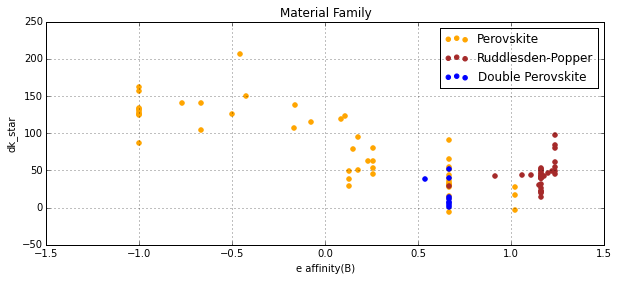

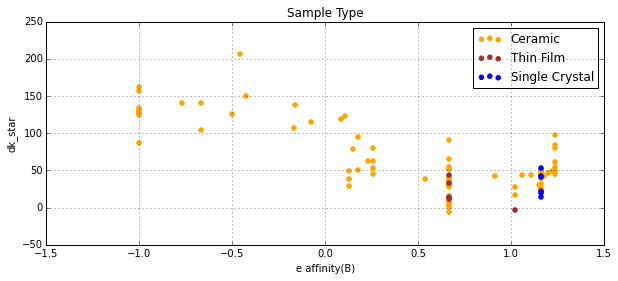

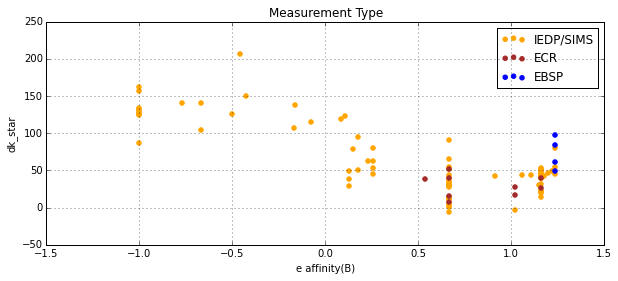

In [7]:
#Plot log(D*k*) vs EA(B) 
train2 = full_data.sort(['e affinity(B)'], ascending=True)

per = train2[train2['family_Perovskite'] == 1]
rp = train2[train2['family_Ruddlesden-Popper'] == 1]
dp = train2[train2['family_Double Perovskite'] == 1]

cer = train2[train2['s_Ceramic'] == 1]
sing = train2[train2['s_Single Crystal'] == 1]
thin = train2[train2['s_Thin Film'] == 1]

iedp = train2[train2['m_IEDP/SIMS'] == 1]
ecr = train2[train2['m_ECR'] == 1]
ebsp = train2[train2['m_EBSP'] == 1]

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(111)
plt.title('Material Family')
per.plot(kind='scatter', x='e affinity(B)', y='dk_star', label='Perovskite', color='orange', ax=ax)
rp.plot(kind='scatter', x='e affinity(B)', y='dk_star', label='Ruddlesden-Popper', color='brown', ax=ax)
dp.plot(kind='scatter', x='e affinity(B)', y='dk_star', label='Double Perovskite', color='blue', ax=ax )

fig = plt.figure(figsize=(10,4))
bx = plt.subplot(111)
plt.title('Sample Type')
cer.plot(kind='scatter', x='e affinity(B)', y='dk_star', label='Ceramic', color='orange', ax=bx)
thin.plot(kind='scatter', x='e affinity(B)', y='dk_star', label='Thin Film', color='brown', ax=bx)
sing.plot(kind='scatter', x='e affinity(B)', y='dk_star', label='Single Crystal', color='blue', ax=bx )

fig = plt.figure(figsize=(10,4))
cx = plt.subplot(111)
plt.title('Measurement Type')
iedp.plot(kind='scatter', x='e affinity(B)', y='dk_star', label='IEDP/SIMS', color='orange', ax=cx)
ecr.plot(kind='scatter', x='e affinity(B)', y='dk_star', label='ECR', color='brown', ax=cx)
ebsp.plot(kind='scatter', x='e affinity(B)', y='dk_star', label='EBSP', color='blue', ax=cx )



plt.show()


This shows that the majority of the data comes from ceramic, Perovskite samples measured with IDEP/SIMS. Unforunately, all other categorizations only show up at EA>0.5.

###I will start by analyzing the training data as a whole (i.e. without the categorizations) using a linear model.
I will remove the material family labels for now, but I will come back to them later. Notice how the double perovskite and Ruddlesden-Popper materials have very narrow ranges of electron affinity (and D\*k\*)

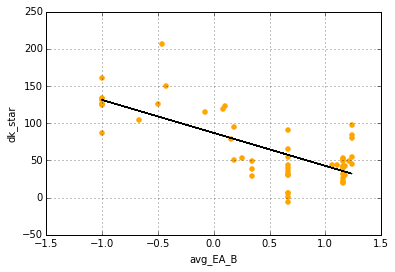

Model: Y = b1*EA(B) 
Score:  0.553081318209


In [8]:
from sklearn import linear_model

model = linear_model.LinearRegression()

#train_x = np.array(train[ ['e affinity(B)'] ])
train_x = np.array(train[ ['avg_EA_B'] ])
train_y = np.array(train[ ['dk_star'] ])

model.fit(train_x,train_y)
pred = model.predict(train_x)
train['reg'] = pd.Series(pred[:,0], index=train.index)


ax = plt.subplot(111)
#train.plot(kind='scatter', x='e affinity(B)', y='dk_star', color='orange', ax=ax)
train.plot(kind='scatter', x='avg_EA_B', y='dk_star', color='orange', ax=ax)
plt.plot(train_x[:,0], pred, color='black')
plt.show()


print 'Model: Y = b1*EA(B) \nScore: ',model.score(train_x, train_y)

###Just over half of the variance is explained with a linear regression of EA on the B-site cation.
###Let's now try a polynomial model using Ridge regularization.

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

second = make_pipeline(PolynomialFeatures(2), Ridge())
second.fit(train_x,train_y[:,0])

third = make_pipeline(PolynomialFeatures(3), Ridge())
third.fit(train_x,train_y[:,0])

print 'Polynomial model scores:'
print 'Second order: Y = b1*EA(B) + b2*EA(B)^2 \nScore: ',second.score(train_x,train_y[:,0])
print 'Third order: Y = b1*EA(B) + b2*EA(B)^2 + b3*EA(B)^3 \nScore: ',third.score(train_x,train_y[:,0])


Polynomial model scores:
Second order: Y = b1*EA(B) + b2*EA(B)^2 
Score:  0.576940969238
Third order: Y = b1*EA(B) + b2*EA(B)^2 + b3*EA(B)^3 
Score:  0.704102717866


Looks like the third order polynomial is a bit better at explaining the variation.

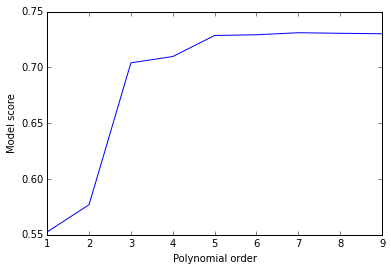

In [10]:
degree = []
score = []
for i in range(1,10):
    model = make_pipeline(PolynomialFeatures(i), Ridge())
    model.fit(train_x, train_y[:,0])
    degree.append(i)
    score.append(model.score(train_x, train_y[:,0]))

plt.plot(degree,score)
plt.xlabel('Polynomial order')
plt.ylabel('Model score')
plt.show()

**The score starts to level off after 3 and completely levels off after 5.**

I am going to stick with order 3 because I worry that anything above might result in overfitting.

**Next, I'll look at the alpha levels for the ridge regularization.**

The default level of alpha is 1.0, but let's see how changing that affects the score for an order 3 polynomial.

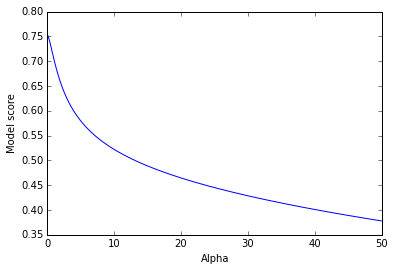

In [11]:
alpha = []
score = []

for i in range(1,500):
    a = 0.1*(i)
    model = make_pipeline(PolynomialFeatures(3), Ridge(alpha=a))
    model.fit(train_x, train_y[:,0])
    alpha.append(a)
    score.append(model.score(train_x,train_y[:,0]))

plt.plot(alpha,score)
plt.xlabel('Alpha')
plt.ylabel('Model score')
plt.show()

**Alpha is the regularization penalty imposed on the model.**

Higher values of alpha impose a higher penalty on terms that don't fit the data well (i.e. shouldn't be in the model) but it also imposes penalties on terms that **should** be in the model.

Smaller values of alpha impose less of a penalty, but may introduce overfitting to the model. I will stick with the default alpha value of 1.0 for the moment.

**Now I will run a test to optimize polynomial order with my cross-validation data set.**

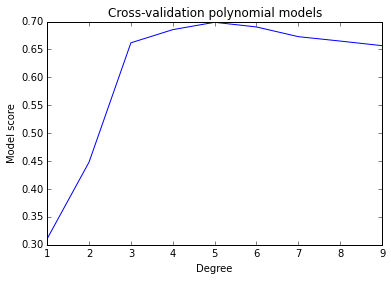

In [12]:
#
degree = []
score = []


cvd['dk_star'] = pd.Series(dk_star(cvd,1000), index=cvd.index)
cvd_y = np.array(cvd[ ['dk_star'] ])
#cvd_x = np.array(cvd[ ['e affinity(B)'] ])
cvd_x = np.array(cvd[ ['avg_EA_B'] ])

for i in range(1,10):
    model = make_pipeline(PolynomialFeatures(i), Ridge())
    model.fit(train_x, train_y[:,0])
    #model.fit(cvd_x, cvd_y[:,0])
    degree.append(i)
    score.append(model.score(cvd_x, cvd_y[:,0]))
    #score.append(model.score(x,y[:,0]))
    
plt.plot(degree,score)
plt.title('Cross-validation polynomial models')
plt.xlabel('Degree')
plt.ylabel('Model score')
plt.show()

####Cross-validation error is minimized at at 5th order polynomial.
To make sure this extends to the test data set, I will run the same model with a polynomial order of 7 on the test data. This order is high, so it seems like this may be overfitting the data, but the model score isn't terribly good so I'll have to introduce more variables later.

In [13]:
model = make_pipeline(PolynomialFeatures(5), Ridge())
model.fit(cvd_x, cvd_y[:,0])

test['dk_star'] = pd.Series(dk_star(test, 1000), index=test.index)
test_y = np.array(cvd[ ['dk_star'] ])
test_x = np.array(cvd[ ['e affinity(B)'] ])
print model.score(test_x, test_y)

0.694574733217


That didn't change the score much from the cross-validation data score, which means the model is consistent across the randomly selected data sets. I will plot the model against the training set for clarity.

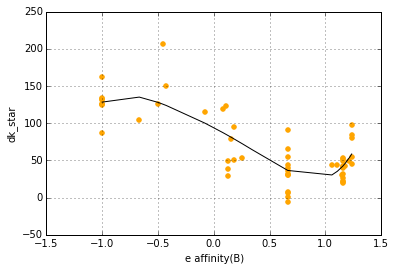

Score:  0.728608137251


In [14]:
model = make_pipeline(PolynomialFeatures(5), Ridge(alpha=1))
model.fit(train_x,train_y[:,0])

x_plot = np.sort(train_x[:,0])
y_plot = model.predict(x_plot[:,np.newaxis])

ax = plt.subplot(111)
train.plot(kind='scatter', x='e affinity(B)', y='dk_star', color='orange', ax=ax)
plt.plot(x_plot, y_plot, color='black')
plt.show()

print 'Score: ',model.score(train_x,train_y)

###Where is the rest of the variability coming from?
I'll take a look at the other quantitative variables in the data sheet. I will run another Ridge regularized regression, this time with other parameters.

###Ionic radii:

Score from A-cation model:  0.29917677362
Score from B-cation model:  0.000809776722633


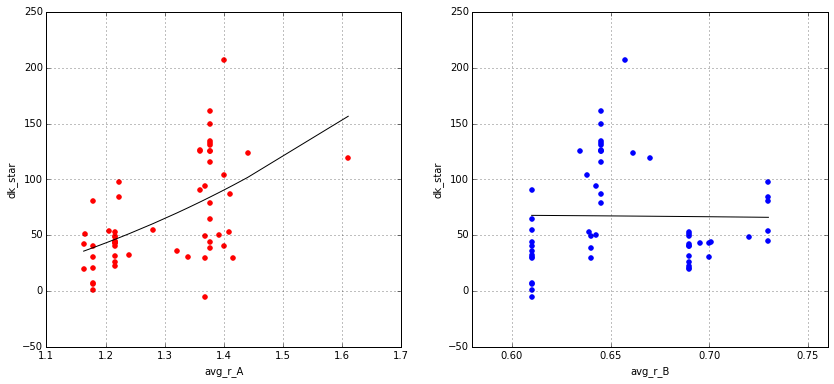

In [15]:
#model = make_pipeline(PolynomialFeatures(3), Ridge(0.5))
#newdata = train[ pd.notnull(train['A-site radius']) & pd.notnull(train['B-site radius']) ]
newdata = train[ pd.notnull(train['avg_r_A']) & pd.notnull(train['avg_r_B']) ]

y = newdata[ ['dk_star'] ]

# A-cation
xa = newdata[ ['avg_r_A']]
amodel = make_pipeline(PolynomialFeatures(5), Ridge())
amodel.fit(xa, y)
xa_plot = xa.sort(['avg_r_A'])
ya_plot = amodel.predict(xa_plot)

# B-cation
xb = newdata[ ['avg_r_B']]
bmodel = make_pipeline(PolynomialFeatures(5), Ridge())
bmodel.fit(xb, y)
xb_plot = xb.sort(['avg_r_B'])
yb_plot = bmodel.predict(xb_plot)

fig = plt.figure(figsize=(14,6))
ax = plt.subplot(1,2,1)
newdata.plot(kind='scatter', x='avg_r_A', y='dk_star', color='red', ax=ax)
plt.plot(xa_plot, ya_plot, color='black')

bx = plt.subplot(1,2,2)
newdata.plot(kind='scatter', x='avg_r_B', y='dk_star', color='blue', ax=bx)
plt.plot(xb_plot, yb_plot, color='black')


print 'Score from A-cation model: ', amodel.score(xa,y)
print 'Score from B-cation model: ', bmodel.score(xb,y)


####The data for these variables don't show a trend and the models don't fit well at all.
I will therefore fail to include ionic radii in the model. **Note that these are 5th order polynomial models that assume roughly linear shape** due to the fact that nothing but extremely high order polynomials would be able to fit this data even remotely well. This is made possible by the regularization.

###d electron count on the B-site cation:

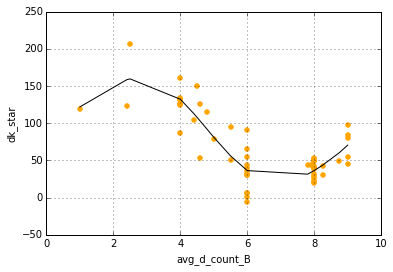

Score from d-electron count model:  0.772043583638


In [16]:
newdata = train[  pd.notnull(train['avg_d_count_B'])  ]

xd = newdata[ ['avg_d_count_B']]
yd = newdata[ ['dk_star'] ]

model = make_pipeline(PolynomialFeatures(7), Ridge(0.5))
model.fit(xd, yd)

xd_plot = xd.sort(['avg_d_count_B'])
yd_plot = model.predict(xd_plot)

ax = plt.subplot(111)
newdata.plot(kind='scatter', x='avg_d_count_B', y='dk_star', color='orange', ax=ax)
plt.plot(xd_plot, yd_plot, color='black')
plt.show()

print 'Score from d-electron count model: ',model.score(xd,yd)

####This model fits pretty well.
It appears that d-electron count and electronegativity (both on the B-site cation) each has an effect on D\*k\*. However, these two values both involve the B-site cation and may thus be linearly dependent (multicollinearity).

###Now I will combine electron affinity and d-electron count with a combined regression.
Since I will be making a 3D plot, showing the predicted values of D\*k\* won't be as helpful as showing the function itself. For that, we'll need the coefficients, plotted on a grid of the two parameters.

###Fit the model:

In [17]:
from sklearn import preprocessing

en_d = train[  pd.notnull(train['avg_d_count_B']) & pd.notnull(train['avg_EA_B']) ]

X = en_d[ ['avg_d_count_B', 'avg_EA_B']]
Y = en_d[ ['dk_star'] ]

model = make_pipeline(PolynomialFeatures(5), Ridge(fit_intercept=True))
model.fit(X, Y)

powers = model.steps[0][-1].powers_
coefs = model.steps[1][-1].coef_[0]

print 'Score: ',model.score(X,Y)

Score:  0.84393997619


###Optimize polynomial with cross-validation data:

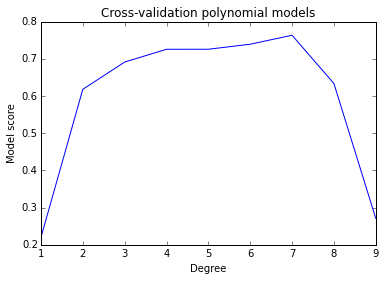

In [18]:
degree = []
score = []

cvd_sub = cvd[ pd.notnull(cvd['avg_d_count_B']) & pd.notnull(cvd['avg_EA_B']) ]
cvd_y = np.array(cvd_sub[ ['dk_star'] ])
cvd_x = np.array(cvd_sub[ ['avg_d_count_B', 'avg_EA_B'] ])

for i in range(1,10):
    model = make_pipeline(PolynomialFeatures(i), Ridge())
    model.fit(X, Y)
    degree.append(i)
    score.append(model.score(cvd_x,cvd_y)) 


plt.plot(degree,score)
plt.title('Cross-validation polynomial models')
plt.xlabel('Degree')
plt.ylabel('Model score')
plt.show()

###Get the score of model for test data with polynomial order = 7

In [19]:
scores = []
std = []

test_sub = test[ pd.notnull(test['avg_d_count_B']) & pd.notnull(test['avg_EA_B']) ]
test_y = np.array(test_sub[ ['dk_star'] ])
test_x = np.array(test_sub[ ['avg_d_count_B', 'avg_EA_B'] ])
model = make_pipeline(PolynomialFeatures(7), Ridge())

model.fit(X,Y)
print model.score(test_x, test_y)

0.856969457431


###Plot it:
In an effort to center the data, I will first subtract the mean from the D\*k\* values. **This will not affect the model.** I also need to center the fitted polynomial about 0 the same way. In this case, the model mean is below 0, so I will add Y_mean to it.

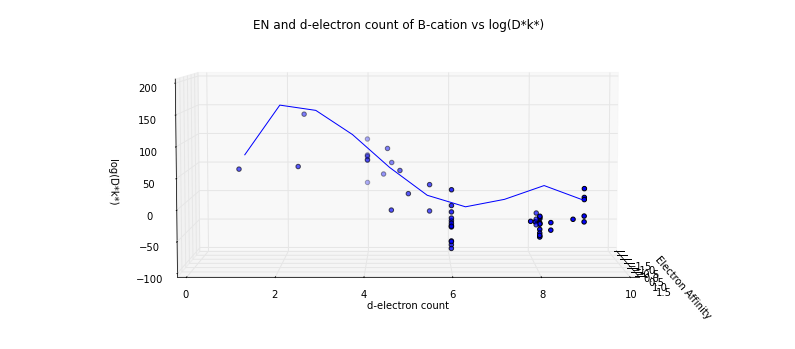

In [20]:
#%matplotlib qt
%matplotlib inline
# Plot a fitted polynomial function on a grid
def fit_poly(x1_min, x1_max, x2_min, x2_max, powers, coefs, center):
    res = 10
    x2 = np.linspace(x1_min, x1_max, res)
    x1 = np.linspace(x2_min, x2_max, res)
    y = []

    for i in range(res):
        yi = 0
        for j,p in enumerate(powers):
            if i==0:
                yi += coefs[0]
            else:
                yi += coefs[j]*(x2[i]**p[0])*(x1[i]**p[1])
        y.append(yi + center)
    return np.array(y), x1, x2


X_plot = X.sort(['avg_EA_B'])
Y_plot = model.predict(X_plot)

Y_mean = np.mean(en_d[ ['dk_star'] ].values)
Y = en_d[ ['dk_star'] ] - Y_mean

yy, x1, x2 = fit_poly(np.min(X['avg_d_count_B']), np.max(X['avg_d_count_B']),
              np.min(X['avg_EA_B']), np.max(X['avg_EA_B']),
              powers, coefs, Y_mean)



from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x1, x2, zs=yy )
ax.scatter(X['avg_EA_B'], X['avg_d_count_B'], Y)
ax.set_title('EN and d-electron count of B-cation vs log(D*k*)')
ax.set_zlabel('log(D*k*)')
ax.set_xlabel('Electron Affinity')
ax.set_ylabel('d-electron count')

ax.view_init(5, 0)
plt.draw()

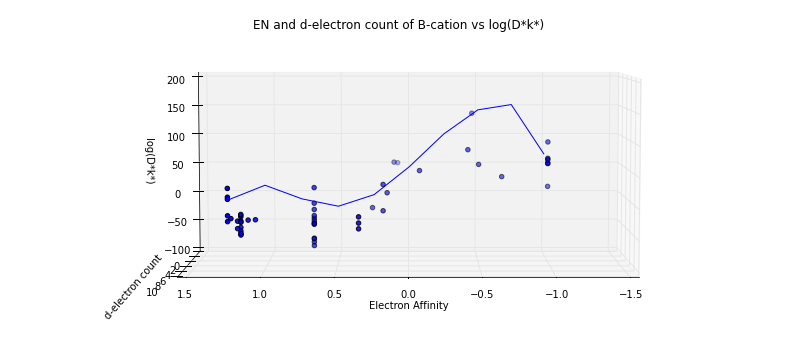

In [21]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x1, x2, zs=yy )
ax.scatter(X['avg_EA_B'], X['avg_d_count_B'], Y)
ax.set_title('EN and d-electron count of B-cation vs log(D*k*)')
ax.set_zlabel('log(D*k*)')
ax.set_xlabel('Electron Affinity')
ax.set_ylabel('d-electron count')
ax.view_init(5,90)
plt.draw()

###A few things to note:

####1) This doesn't fit the data terribly well, despite the high score.
This may be because the fitted line is coming from optimizing the model through cross validation, but it is being plotted against training data. This is an indication that my cross validation isn't going so great.

####2) It looks like the shape is roughly the same for both variables.
That's probably because they are both atomic properties of transition metals. Therefore, these two parameters have some multicollinearity.

##What about the standard deviation?
I did the above analysis with a random seed, which means the sets of data were the same every time the notebook runs. Let's look at what happens when I use truly random sets of data.

In [24]:
np.random.seed(None)

In [23]:
scores =[]
orders = []

for cycle in range(300):
    s = np.random.rand(len(full_data)) < 0.6

    train = full_data[s]
    other = full_data[~s]

    s2 = np.random.rand(len(other)) < 0.5
    cvd = other[s2]
    test = other[~s2]
    
    train['dk_star'] = pd.Series(dk_star(train,1000), index=train.index)
    cvd['dk_star'] = pd.Series(dk_star(cvd,1000), index=cvd.index)
    
    degree = []
    score = []

    cvd_sub = cvd[ pd.notnull(cvd['avg_d_count_B']) & pd.notnull(cvd['avg_EA_B']) ]
    cvd_y = np.array(cvd_sub[ ['dk_star'] ])
    cvd_x = np.array(cvd_sub[ ['avg_d_count_B', 'avg_EA_B'] ])

    for i in range(1,10):
        model = make_pipeline(PolynomialFeatures(i), Ridge())
        model.fit(X, Y)
        degree.append(i)
        score.append(model.score(cvd_x,cvd_y)) 

    order = degree[np.argmax(np.array(score))]
    orders.append(order)

    test['dk_star'] = pd.Series(dk_star(test,1000), index=test.index)

    model = make_pipeline(PolynomialFeatures(3), Ridge()).fit(train[['avg_d_count_B',
        'avg_EA_B']],train['dk_star'])
    scores.append(model.score(test[['avg_d_count_B','avg_EA_B']],test['dk_star']))


print 'Model score: ' + str(np.mean(np.array(scores))) + ' +/- ' + str(np.std(np.array(scores)))
print 'Polynomial order: ' + str(np.mean(np.array(orders))) +' +/- ' + str(np.std(np.array(orders)))

Model score: 0.747294866961 +/- 0.131553978103
Polynomial order: 4.36666666667 +/- 2.80218168972


###The standard deviation of the model score is very high and the standard deviation of the polynomial order used in the model is unacceptably high.
This suggests the current methodology is a bad way to divide and analyze my data set.

#Conclusion:
This model was created with cross validation made from splitting the data set into 60/20/20 ratios. The problem is there is **too little data** to make a meaningful model and the results appear to overfit the data.

In the next notebook, I will use a 'leave-k-out' cross validation algorithm to bring these standard deivations down. The goal is to have a model with a consistent order, which produces consistent model scores.